# Kaggle toxic-comment-classification-challenge

In [13]:
from __future__ import print_function, division
from builtins import range
import sys

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

# Configs

In [15]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

# load in pre-trained word vectors

In [25]:

print('word vectors')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM),encoding="utf8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


# importing training data

In [27]:
train = pd.read_csv("train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
target = train[labels].values


# Converting the sentences (strings) into integers

In [28]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [29]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])


max sequence length: 1400
min sequence length: 0
median sequence length: 35


In [30]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


Found 210337 unique tokens.


# N x T matrix

In [32]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


# Embedding matrix

In [35]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():   
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
              embedding_matrix[i] = embedding_vector

In [36]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


# CNN 

In [38]:
X = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(X)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
Y = Dense(len(labels), activation='sigmoid')(x)


In [40]:
model = Model(X, Y)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


In [42]:
print('Training model...')
cnn = model.fit(
  data,
  target,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 472s 4ms/step - loss: 0.0892 - acc: 0.9717 - val_loss: 0.0776 - val_acc: 0.9735
Epoch 2/10
127656/127656 [==============================] - 375s 3ms/step - loss: 0.0722 - acc: 0.9761 - val_loss: 0.0734 - val_acc: 0.9752
Epoch 3/10
127656/127656 [==============================] - 404s 3ms/step - loss: 0.0692 - acc: 0.9768 - val_loss: 0.0691 - val_acc: 0.9766
Epoch 4/10
127656/127656 [==============================] - 418s 3ms/step - loss: 0.0670 - acc: 0.9775 - val_loss: 0.0714 - val_acc: 0.9761
Epoch 5/10
127656/127656 [==============================] - 450s 4ms/step - loss: 0.0655 - acc: 0.9776 - val_loss: 0.0745 - val_acc: 0.9738
Epoch 6/10
127656/127656 [==============================] - 510s 4ms/step - loss: 0.0638 - acc: 0.9781 - val_loss: 0.0724 - val_acc: 0.9766
Epoch 7/10
127656/127656 [==============================] - 534s 4ms/step - loss: 0.0630 - 

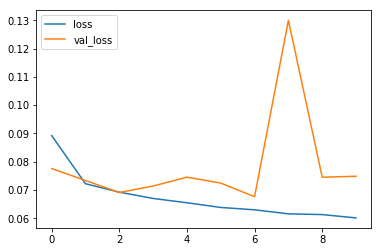

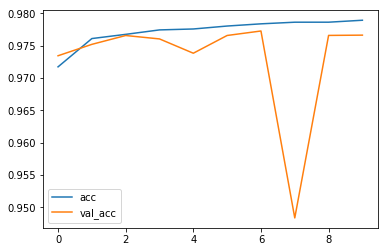

In [46]:
plt.plot(cnn.history['loss'], label='loss')
plt.plot(cnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.plot(cnn.history['acc'], label='acc')
plt.plot(cnn.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [47]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(target[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9710611137251685


# RNN

In [83]:
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
      from keras.layers import CuDNNLSTM as LSTM
      from keras.layers import CuDNNGRU as GRU

In [84]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIMM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHSS = 5

In [87]:


inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
x2 = embedding_layer(inputs)
x2 = Bidirectional(LSTM(15, return_sequences=True))(x2)
x2 = GlobalMaxPool1D()(x2)
outputs = Dense(len(labels), activation="sigmoid")(x2)

model = Model(inputs, outputs)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)


In [89]:
print('Training model...')
rnn = model.fit(
  data,
  target,
  batch_size=BATCH_SIZE,
  epochs=EPOCHSS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 347s 3ms/step - loss: 0.0672 - acc: 0.9774 - val_loss: 0.0552 - val_acc: 0.9806
Epoch 2/5
127656/127656 [==============================] - 346s 3ms/step - loss: 0.0522 - acc: 0.9813 - val_loss: 0.0528 - val_acc: 0.9807
Epoch 3/5
127656/127656 [==============================] - 396s 3ms/step - loss: 0.0495 - acc: 0.9820 - val_loss: 0.0509 - val_acc: 0.9817
Epoch 4/5
127656/127656 [==============================] - 467s 4ms/step - loss: 0.0482 - acc: 0.9825 - val_loss: 0.0517 - val_acc: 0.9811
Epoch 5/5
127656/127656 [==============================] - 422s 3ms/step - loss: 0.0470 - acc: 0.9826 - val_loss: 0.0503 - val_acc: 0.9818


In [91]:
pred = model.predict(data)
auccs = []
for j in range(6):
    aucc = roc_auc_score(target[:,j], pred[:,j])
    auccs.append(aucc)
print(np.mean(auccs))


0.9821262093904505


# RNN with Bidirectional = 98%
# CNN = 97% 
# of Accuracy 127656 train samples, validation on 31915 test samples